# HONN pytorch models playground
place for testing the pytorch model

In [7]:
# Import libs

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from src import HONN

## Create test data
Generate random sinus data for testing the HONN models.

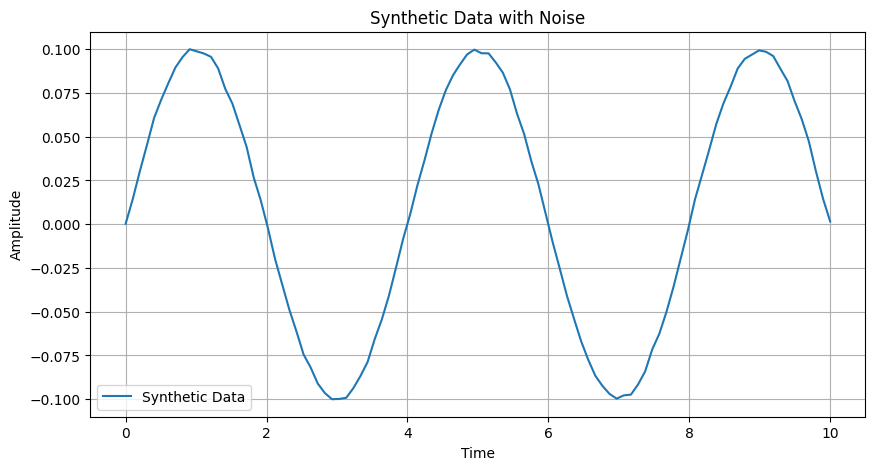

In [8]:
freqs = [0.25]
amps = [0.1, 0.2, 0.3]
phases = [0, 0.5, 1]
noise_lvl = 0.001
t_max = 10
n_samples = 100
t = np.linspace(0, t_max, n_samples)
# Generate synthetic data
signals = [
    amp * np.sin(2 * np.pi * freq * t + phase) for freq, amp, phase in zip(freqs, amps, phases)
]
noise = np.random.normal(0, noise_lvl, t.shape)
data = np.sum(signals, axis=0) + noise
# Plot the synthetic data
plt.figure(figsize=(10, 5))
plt.plot(t, data, label="Synthetic Data")
plt.title("Synthetic Data with Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [9]:
# Prepare data for the models
N = data.shape[0]
prev_vals = 5  # Number of historical values to use
prediction_horizon = 1  # Predict two steps ahead

# Initialize X and y
X = np.zeros((N - prev_vals - prediction_horizon + 1, prev_vals))
y = np.zeros((N - prev_vals - prediction_horizon + 1, 1))

# Create historical values and targets
for i in range(prev_vals, N - prediction_horizon + 1):
    X[i - prev_vals] = data[i - prev_vals : i][::-1]  # Reverse to maintain chronological order
    y[i - prev_vals] = data[
        i + prediction_horizon - 1
    ]  # Target is `prediction_horizon` steps ahead

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Data shape: {data.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
# Print the first 3 train/test pairs
print("First 3 training pairs:")
for i in range(3):
    print(f"X_train[{i}]: {X_train[i]}, y_train[{i}]: {y_train[i]}")

Data shape: (100,)
X_train shape: (76, 5), y_train shape: (76, 1)
X_test shape: (19, 5), y_test shape: (19, 1)
First 3 training pairs:
X_train[0]: [0.80360208 0.72659075 0.6515628  0.5716126  0.50113027], y_train[0]: [0.85585172]
X_train[1]: [0.85585172 0.80360208 0.72659075 0.6515628  0.5716126 ], y_train[1]: [0.90295439]
X_train[2]: [0.90295439 0.85585172 0.80360208 0.72659075 0.6515628 ], y_train[2]: [0.94794395]


In [13]:
# Train the HONU model
input_shape = X.shape[1]
output_shape = 1
output_type = "linear"
orders = [2, 3]
layer_size = 4

lr = 0.001
batch_size = 10
epochs = 250

model = HONN(input_shape, output_shape, layer_size, orders, output_type=output_type)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

# Convert data to PyTorch tensors and add batch dimension
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Training loop
loss_history_train = np.zeros(epochs)  # To store average loss for each epoch
loss_history_test = np.zeros(epochs)  # To store average loss for each epoch
for epoch in tqdm(range(epochs), desc="Training Progress"):
    permutation = torch.randperm(X_train_tensor.size(0))
    epoch_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        input_batch, target_batch = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(input_batch)
        loss = loss_fn(outputs, target_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / (X_train_tensor.size(0) // batch_size)
    loss_history_train[epoch] = avg_loss  # Save the average loss for this epoch

    # Test the model on the test set
    epoch_loss_test = 0.0
    for i in range(0, X_test_tensor.size(0), batch_size):
        input_batch, target_batch = (
            X_test_tensor[i : i + batch_size],
            y_test_tensor[i : i + batch_size],
        )

        with torch.no_grad():
            outputs = model(input_batch)
            loss = loss_fn(outputs, target_batch)
            epoch_loss_test += loss.item()

    avg_loss_test = epoch_loss_test / (X_test_tensor.size(0) // batch_size)
    loss_history_test[epoch] = avg_loss_test  # Save the average loss for this epoch

# Print the achieved training loss
print(f"Achieved Training Loss: {loss_history_train[-1]:.6f}")
# Print the achieved testing loss
print(f"Achieved Testing Loss: {loss_history_test[-1]:.6f}")


Training Progress: 100%|██████████| 250/250 [00:02<00:00, 123.21it/s]

Achieved Training Loss: 0.000354
Achieved Testing Loss: 0.000225


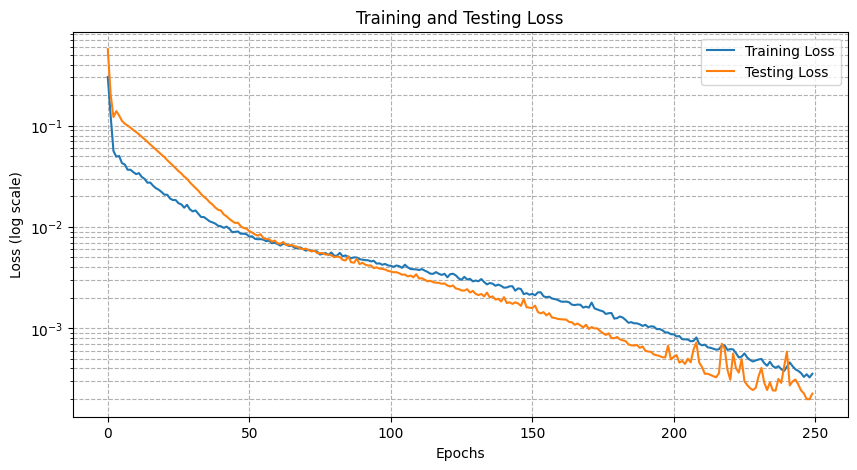

In [14]:
# Show training and testing loss on a log scale
plt.figure(figsize=(10, 5))
plt.plot(loss_history_train, label="Training Loss")
plt.plot(loss_history_test, label="Testing Loss")
plt.yscale("log")  # set y-axis to logarithmic scale
plt.title("Training and Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(which="both", ls="--")
plt.show()

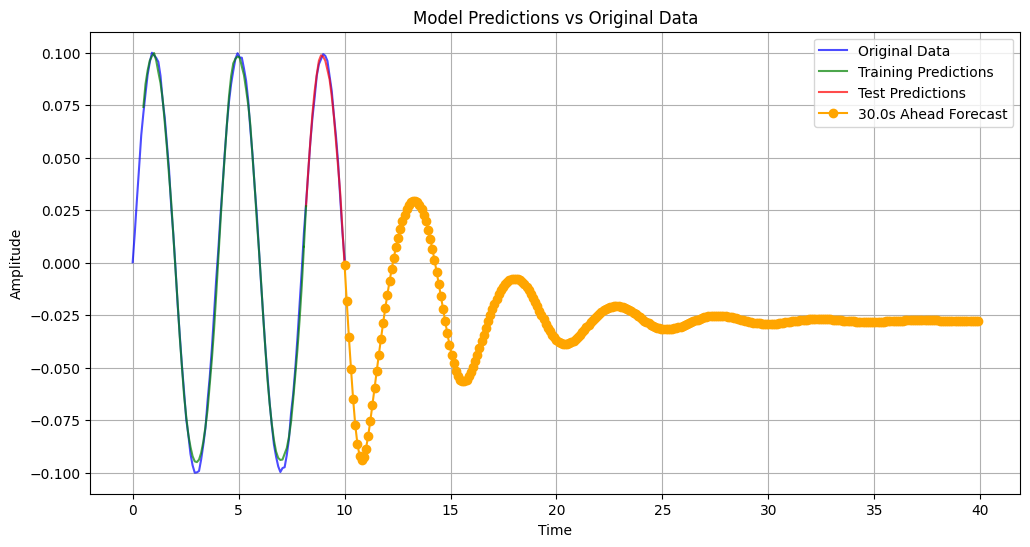

In [15]:
# Visualize model predictions
plt.figure(figsize=(12, 6))

# Original data
plt.plot(t, data, label="Original Data", color="blue", alpha=0.7)

# Model predictions on training data
train_predictions = model(X_train_tensor).detach().numpy()
train_predictions = scaler_y.inverse_transform(train_predictions)
# shift by prev_vals + (prediction_horizon - 1)
train_time = t[
    prev_vals + prediction_horizon - 1 : prev_vals + prediction_horizon - 1 + len(train_predictions)
]
plt.plot(train_time, train_predictions, label="Training Predictions", color="green", alpha=0.7)

# Model predictions on test data
test_predictions = model(X_test_tensor).detach().numpy()
test_predictions = scaler_y.inverse_transform(test_predictions)
# start after the end of train predictions, also shifted
test_time = t[
    prev_vals + prediction_horizon - 1 + len(train_predictions) : prev_vals
    + prediction_horizon
    - 1
    + len(train_predictions)
    + len(test_predictions)
]
plt.plot(test_time, test_predictions, label="Test Predictions", color="red", alpha=0.7)

# Connect last train point to first test point
if len(train_predictions) and len(test_predictions):
    plt.plot(
        [train_time[-1], test_time[0]],
        [train_predictions[-1], test_predictions[0]],
        color="green",
        alpha=0.7,
    )

# --- Multi‐step forecast beyond end of data (1 second ahead) ---
dt = t[1] - t[0]
t_ahead = 30.0
n_future = int(t_ahead / dt)

# start from last test‐window (normalized)
window = X_test_tensor[-1].clone().squeeze()
future_norm = []

model.eval()
with torch.no_grad():
    for _ in range(n_future):
        pred = model(window.unsqueeze(0)).squeeze()
        future_norm.append(pred.item())
        window = torch.cat([pred.unsqueeze(0), window[:-1]])

# back to original scale
future_preds = scaler_y.inverse_transform(
    np.array(future_norm).reshape(-1, 1)
).flatten()

# build future time axis (exactly n_future steps)
future_times = test_time[-1] + np.arange(0, n_future) * dt




plt.plot(future_times, future_preds,
         color="orange", marker="o", label=f"{t_ahead}s Ahead Forecast")

# Plot settings
plt.title("Model Predictions vs Original Data")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [16]:
for name, param in model.named_parameters():
    print(name, param.size())

honu.0.weight torch.Size([21])
honu.1.weight torch.Size([56])
honu.2.weight torch.Size([21])
honu.3.weight torch.Size([56])
head.weight torch.Size([1, 4])
head.bias torch.Size([1])


In [17]:
print(model)

HONN(
  in_features=5,
  out_features=1,
  layer_size=4,
  output_type='linear',
  head=Linear(in_features=4, out_features=1, bias=True),
  honu=ModuleList(
  (0): HONU(in_features=5, polynomial_order=2, bias=True, activation=identity)
  (1): HONU(in_features=5, polynomial_order=3, bias=True, activation=identity)
  (2): HONU(in_features=5, polynomial_order=2, bias=True, activation=identity)
  (3): HONU(in_features=5, polynomial_order=3, bias=True, activation=identity)
)
  )



In [18]:
for name, param in model.honu.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([ 0.0257,  0.2995,  0.1988,  0.0841, -0.0413, -0.1732,  0.1049,  0.0738,
         0.0519,  0.0282,  0.0145,  0.0598,  0.0380,  0.0204, -0.0008,  0.0203,
         0.0010, -0.0144, -0.0199, -0.0369, -0.0518], requires_grad=True)
1.weight Parameter containing:
tensor([ 0.0340,  0.2490,  0.1674,  0.0736, -0.0264, -0.1248,  0.0935,  0.0729,
         0.0520,  0.0355,  0.0125,  0.0545,  0.0352,  0.0242,  0.0014,  0.0157,
         0.0011, -0.0087, -0.0149, -0.0317, -0.0473, -0.0098, -0.0216, -0.0259,
        -0.0180, -0.0227, -0.0214, -0.0212, -0.0145, -0.0170, -0.0185, -0.0134,
        -0.0072, -0.0107,  0.0046,  0.0120, -0.0184, -0.0141, -0.0121, -0.0044,
        -0.0176, -0.0038,  0.0029, -0.0044,  0.0062,  0.0181, -0.0115,  0.0025,
         0.0033,  0.0025,  0.0134,  0.0223,  0.0110,  0.0158,  0.0295,  0.0272],
       requires_grad=True)
2.weight Parameter containing:
tensor([ 0.0265,  0.2769,  0.1883,  0.0796, -0.0309, -0.1516,  0.0986,  0.0748,
     